<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2023/blob/main/Module%204/MidTerm_1_Solutions2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MidTerm - 1 for the Fall 2023 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin
- EELS data by Kevin Roccapriore, Oak Ridge National Laboratory
- Solutions by Mani Valleti

Special point:
- ChatGPT will augment your power as a coder
- If and only if you know what you want to accomplish!

# Imports



0. Add imports as necessary

In [1]:
from copy import deepcopy as dc

import numpy as np
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import keras

# Problem 1 - PCA

1. Create the data set:
- Import the MNIST data set (from Keras)
- Select the images correspponding to single digit (e.g. 7)
- Run the PCA analysis on images

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# Normalizing the dataset to fall between 0 and 1
x_train, x_test = x_train/255, x_test/255

11490434/11490434 [==============================] - 0s 0us/step


(6265, 28, 28)


Text(0.5, 1.0, 'Scree plot')

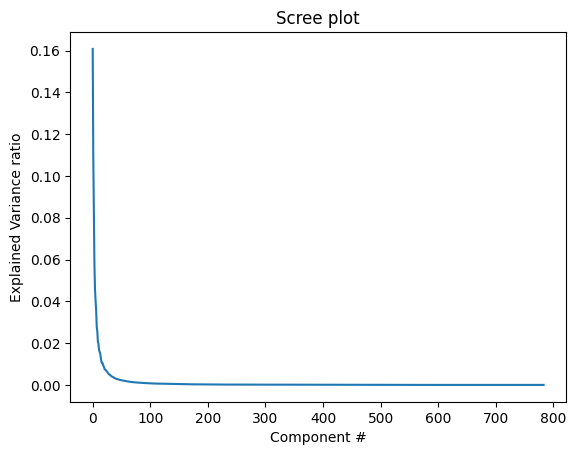

In [3]:
# Select the images corresponding to single digit (e.g. 7)
x_train7 = x_train[y_train == 7]
y_train7 = y_train[y_train == 7]

print(x_train7.shape)

# Run the PCA analysis on images
pca1 = decomposition.PCA(n_components = 28*28)
pca1.fit(x_train7.reshape([-1, 28*28]))

# Visualize the scree plot

plt.plot(np.arange(28*28), pca1.explained_variance_ratio_)

plt.xlabel('Component #')
plt.ylabel('Explained Variance ratio')
plt.title('Scree plot')

Text(0.5, 1.0, 'Second PCA Component')

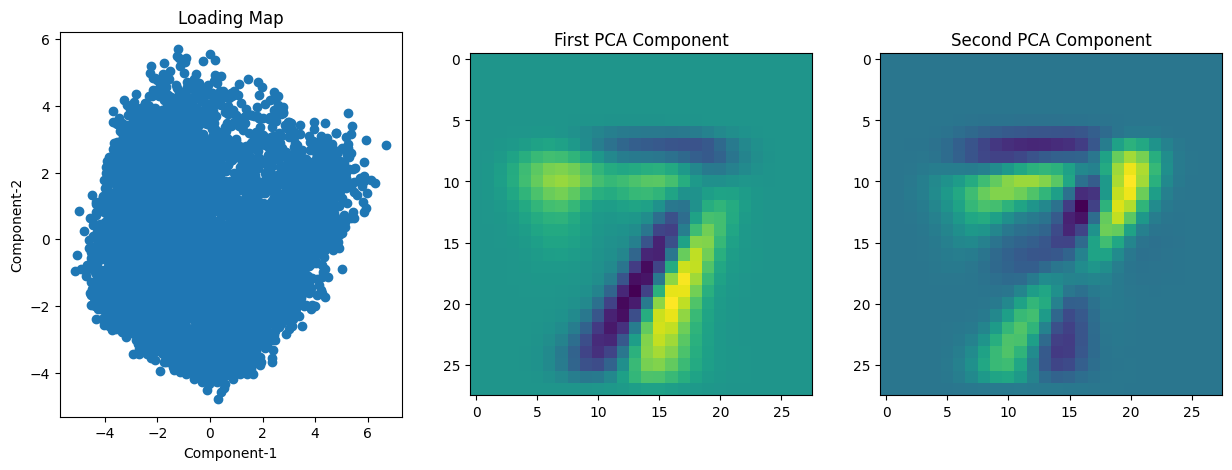

In [4]:
# Visualize the PCA components and loadings distribution (the first two components)

x_train7_loadingmap = pca1.transform(x_train7.reshape([-1, 28*28]))

fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))
ax[0].scatter(x_train7_loadingmap[:, 0], x_train7_loadingmap[:, 1])
ax[0].set_xlabel('Component-1')
ax[0].set_ylabel('Component-2')
ax[0].set_title('Loading Map')

ax[1].imshow(pca1.components_[0].reshape([28, 28]))
ax[1].set_title('First PCA Component')
ax[2].imshow(pca1.components_[1].reshape([28, 28]))
ax[2].set_title('Second PCA Component')


4. Generative model:
- run the PCA analysis with 2 components
- sample the loading space with the rectangular grid
- generate the images from the loading space (i.e. create latent representation)
- do you observe any trends in images across the loading space?

In [5]:
# Sampling the loading space with a rectangular grid

# Here we get the limits to the 'loading space' from the loading map
grid_x = np.linspace(-5, 6, 9)
grid_y = np.linspace(-5, 6, 9)

# We create a large numpy array to fit all the figures
figure = np.zeros([28*9, 28*9])

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        imdec = np.dot(np.array([[xi, yi]]), pca1.components_[0:2]).reshape([28, 28])
        figure[i * 28: (i + 1) * 28,
                j * 28: (j + 1) * 28] = imdec

Text(0, 0.5, '$z_2$')

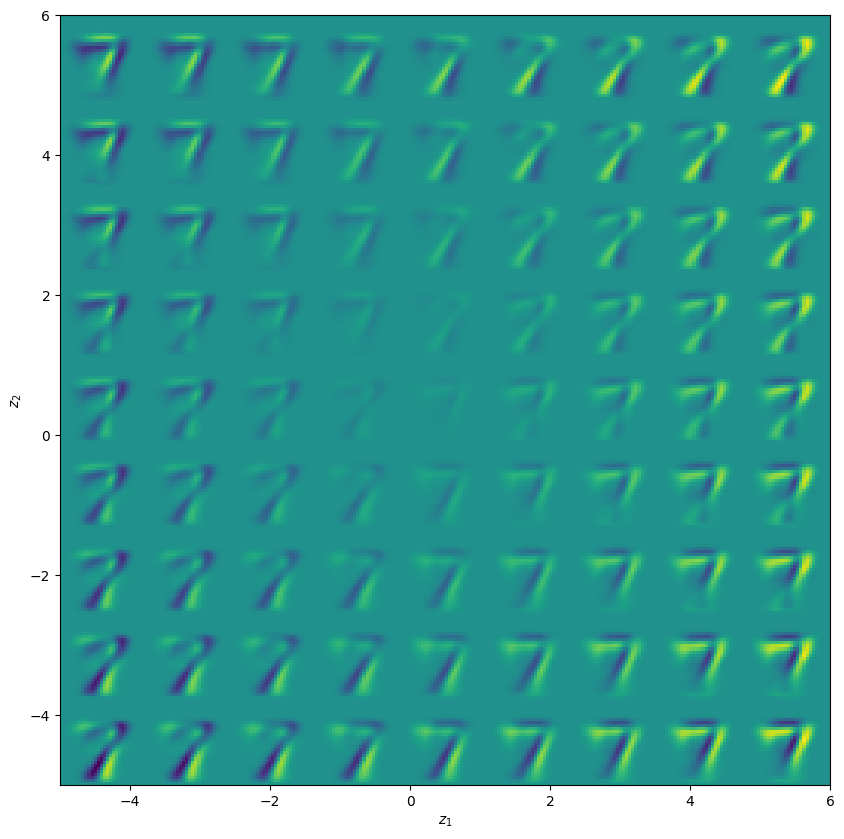

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(figure, origin="upper",
            extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")

- do you observe any trends in images across the loading space?

The shape of the 7s going from left to right and top to bottom. Also, as you move towards the center, the intensity decreases.

Something for the students to think about:
-Why do you see two 7s in each image? (Yellow and blue)

5. In the PCA generative model, each image is represented by 2 PCA loadings. Where does the information to "reconstruct" images come from?  

A. The information from components of PCA. Remember the components are a linear combination of the dimensions we started with. (The first two components are visualized a few cells ago.)

6. (Optional). Create a function that analyzes the "writing style" of the reconstructed image, meaning function transforming (image) -> (several scalar descriptors). For example, it can be the tilt and axis ratio of the tensor of moments of inertia for binarized image. Map this function over the latent space of the model.  

A. This is an open ended question hinged on representing the entire image using a scalar. The distribution of this scalar in the latent space is what we are looking for.

# Problem 2 - LDA

7. Here, we will run the LDA on the MNIST data set.
- Identify (any) 3 digits that you would like to explore and assign as classes 1, 2, and 3
- Designate all other digits as class 0
- Run the LDA analysis
- If the analysis takes too long (>5 min), decimate the data set as [::10]

I observed that the labels to the sklear.discriminant_analysis.LDA shouldn't have to be ordered. That means we can have 0, 1, and 8 as the labels instead of re-labeling them to [1, 2, 3]. So we will make a copy of y_train and use the labels from there. The elements corresponding to all the other classes will be set to 10.

In [7]:
# The 3 classes that we pick are 0,1, and 8 because the same results will be used
# to answer the following questions as well
new_labels = np.zeros_like(y_train) + 10
new_labels[y_train == 0] = 0
new_labels[y_train == 1] = 1
new_labels[y_train == 8] = 8

# Here we pick the training dataset.
# The array 'new_labels' will be used to filter out x_train to include just
#the data-points from the classes 0, 1, and 8
x_train_LDA = x_train[new_labels!=10]
y_train_LDA = new_labels[new_labels!=10]

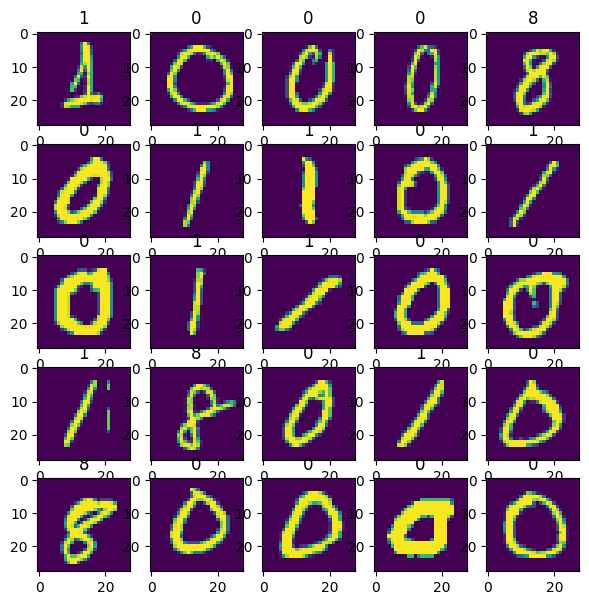

In [8]:
# Visualize the training dataset for the LDA.
# This is to make sure that the code in the previous cell worked as expected
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (7, 7))
inds = np.random.choice(np.arange(x_train_LDA.shape[0]), size = 25, replace = False)

for ind, ax in zip(inds, axes.flat):
    ax.imshow(x_train_LDA[ind])
    ax.set_title(str(y_train_LDA[ind]))

In [9]:
# Let's run the LDA now
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(x_train_LDA.reshape([-1, 28*28]), y_train_LDA)

LinearDiscriminantAnalysis()

Once we train the LDA, there's multiple ways of visualizing the results.
First, we can visulaize the means of the predicted classes

Text(0.5, 0.98, ' Means of the predicted classes ')

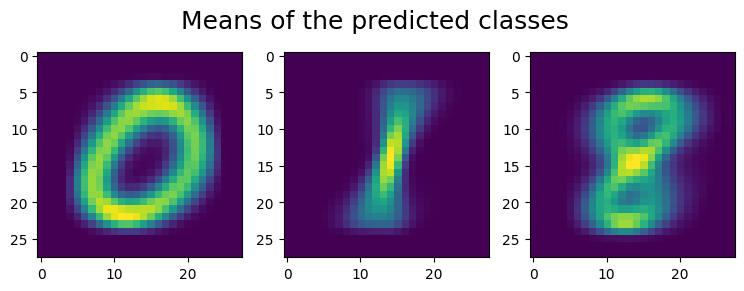

In [10]:
fig, ax = plt.subplots(ncols = 3, figsize = (9, 3))

for i in range(3):
    ax[i].imshow(lda.means_[i].reshape([28, 28]))

fig.suptitle(' Means of the predicted classes ', fontsize=18)

8. Visualize the LDA results in the 2D LDA feature space. Use the original digits as labels.

Here, we will visulize the training set in the "Latent space" where each point is colored using the true class/ predicted class

LDA's explained variance ratio:  [0.8243179 0.1756821]
The accuracy of the classifier on the training dataset : 96.88917692806221 %


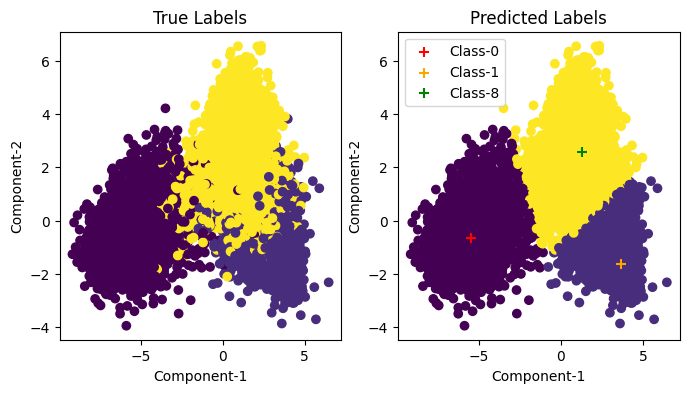

In [11]:
print("LDA's explained variance ratio: ", lda.explained_variance_ratio_)

# Predicting classes of training dataset
y_predict_train_LDA = lda.predict(x_train_LDA.reshape([-1, 28*28]))

# Once we have the predicted labels, its easy to compute the accuracy directly
print('The accuracy of the classifier on the training dataset :',
      np.sum(y_predict_train_LDA == y_train_LDA)*100/len(y_train_LDA), '%')


# Projecting the training dataset into the latent space
x_train_LDA_transformed = lda.transform(x_train_LDA.reshape([-1, 28*28]))

# Now let's visualize the results
fig, ax = plt.subplots(ncols = 2, figsize = (8,4))



ax[0].scatter(x_train_LDA_transformed[:, 0], x_train_LDA_transformed[:, 1], c = y_train_LDA)
ax[0].set_xlabel('Component-1')
ax[0].set_ylabel('Component-2')
ax[0].set_title('True Labels')

ax[1].scatter(x_train_LDA_transformed[:, 0], x_train_LDA_transformed[:, 1], c = y_predict_train_LDA)
# We can also plot the means of the classes predicted by LDA
colors = ['r', 'orange', 'g']
names = ['Class-0', 'Class-1', 'Class-8']
for i in range(3):
    ax[1].scatter(lda.transform(lda.means_[i][None])[:, 0],
                  lda.transform(lda.means_[i][None])[:, 1],
                  marker = '+', s = 50, c = colors[i],
                  label=names[i])
ax[1].set_xlabel('Component-1')
ax[1].set_ylabel('Component-2')
ax[1].set_title('Predicted Labels')
ax[1].legend()

9. Run the analysis when the selected classes are "0", "1", and "8". Where will be the "6" and "9" in the LDA feature space

Text(0.5, 1.0, 'Class-9 in latent space')

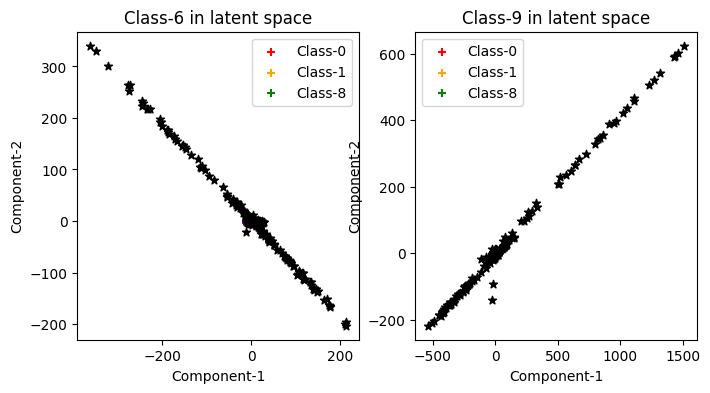

In [12]:
# We can plot the images corresponding to '6' and '9' and see where they are placed

fig, ax = plt.subplots(ncols = 2, figsize = (8, 4))

# First we will start by plotting the training data and means of the classes
ax[0].scatter(x_train_LDA_transformed[:, 0], x_train_LDA_transformed[:, 1], c = y_predict_train_LDA)
colors = ['r', 'orange', 'g']
names = ['Class-0', 'Class-1', 'Class-8']
for i in range(3):
    ax[0].scatter(lda.transform(lda.means_[i][None])[:, 0],
                  lda.transform(lda.means_[i][None])[:, 1],
                  c = colors[i], marker = '+', label=names[i])
ax[0].set_xlabel('Component-1')
ax[0].set_ylabel('Component-2')
ax[0].legend()

ax[1].scatter(x_train_LDA_transformed[:, 0], x_train_LDA_transformed[:, 1], c = y_predict_train_LDA)
colors = ['r', 'orange', 'g']
names = ['Class-0', 'Class-1', 'Class-8']
for i in range(3):
    ax[1].scatter(lda.transform(lda.means_[i][None])[:, 0],
                  lda.transform(lda.means_[i][None])[:, 1],
                  c = colors[i], marker = '+', label=names[i])
ax[1].set_xlabel('Component-1')
ax[1].set_ylabel('Component-2')
ax[1].set_title('Predicted Labels')
ax[1].legend()




#now we will plot the images of 6 in the latent space in the first plot
# and images of 9 in the second plot

x_test6 = x_test[y_test == 6]
ax[0].scatter(lda.transform(x_test6.reshape([-1, 28*28]))[:, 0],
              lda.transform(x_test6.reshape([-1, 28*28]))[:, 1],
              marker = '*', c = 'k')

ax[0].set_title('Class-6 in latent space')

x_test9 = x_test[y_test == 9]
ax[1].scatter(lda.transform(x_test9.reshape([-1, 28*28]))[:, 0],
              lda.transform(x_test9.reshape([-1, 28*28]))[:, 1],
              marker = '*', c = 'k')
ax[1].set_title('Class-9 in latent space')


The reason for the plot above is that the classifier has never seen the images correspoding to 6 and 9 while training and the latent space is not made to accomodate them. So we will just crop the image to the limits of the training set to observe the patterns there.

(-7.0, 7.0)

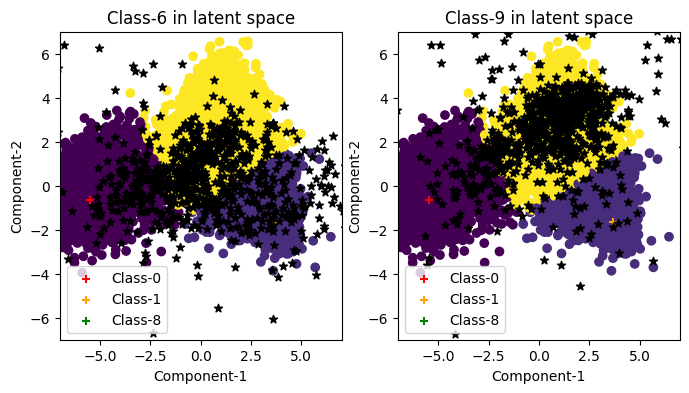

In [13]:
x_limits = [-7, 7]  # replace with your desired x limits
y_limits = [-7, 7]  # replace with your desired y limits

fig, ax = plt.subplots(ncols = 2, figsize = (8, 4))

# First we will start by plotting the training data and means of the classes
ax[0].scatter(x_train_LDA_transformed[:, 0], x_train_LDA_transformed[:, 1], c = y_predict_train_LDA)
colors = ['r', 'orange', 'g']
names = ['Class-0', 'Class-1', 'Class-8']
for i in range(3):
    ax[0].scatter(lda.transform(lda.means_[i][None])[:, 0],
                  lda.transform(lda.means_[i][None])[:, 1],
                  c = colors[i], marker = '+', label=names[i])
ax[0].set_xlabel('Component-1')
ax[0].set_ylabel('Component-2')
ax[0].legend()

ax[1].scatter(x_train_LDA_transformed[:, 0], x_train_LDA_transformed[:, 1], c = y_predict_train_LDA)
colors = ['r', 'orange', 'g']
names = ['Class-0', 'Class-1', 'Class-8']
for i in range(3):
    ax[1].scatter(lda.transform(lda.means_[i][None])[:, 0],
                  lda.transform(lda.means_[i][None])[:, 1],
                  c = colors[i], marker = '+', label=names[i])
ax[1].set_xlabel('Component-1')
ax[1].set_ylabel('Component-2')
ax[1].set_title('Predicted Labels')
ax[1].legend()




#now we will plot the images of 6 in the latent space in the first plot
# and images of 9 in the second plot

x_test6 = x_test[y_test == 6]
ax[0].scatter(lda.transform(x_test6.reshape([-1, 28*28]))[:, 0],
              lda.transform(x_test6.reshape([-1, 28*28]))[:, 1],
              marker = '*', c = 'k')

ax[0].set_title('Class-6 in latent space')

x_test9 = x_test[y_test == 9]
ax[1].scatter(lda.transform(x_test9.reshape([-1, 28*28]))[:, 0],
              lda.transform(x_test9.reshape([-1, 28*28]))[:, 1],
              marker = '*', c = 'k')
ax[1].set_title('Class-9 in latent space')

ax[0].set_xlim(x_limits)
ax[0].set_ylim(y_limits)

ax[1].set_xlim(x_limits)
ax[1].set_ylim(y_limits)

The latent representations of unseen digits are closer to the classes that share the features with them. The images with digit-9 has features share with 0 and 8 (circles or cruved edges). Surprizingly, the images with digits 6 share features with all the three classes. Plotting the images of different styles of 6 and the training dataset will reveal these features.

# Problem 3 - QDA on EELS

Download EELS data. This is 12 EELS spectral data sets of indium-tin oxide cubes aquired by Kevin Roccapriore, measured at different resolutions and geometries. Pick the one you like!

In [14]:
%%capture
!wget https://www.dropbox.com/s/nicyvttpihzh1cd/Plasmonic_sets_7222021_fixed.npy
loadedfile = np.load("Plasmonic_sets_7222021_fixed.npy", allow_pickle=True).tolist()

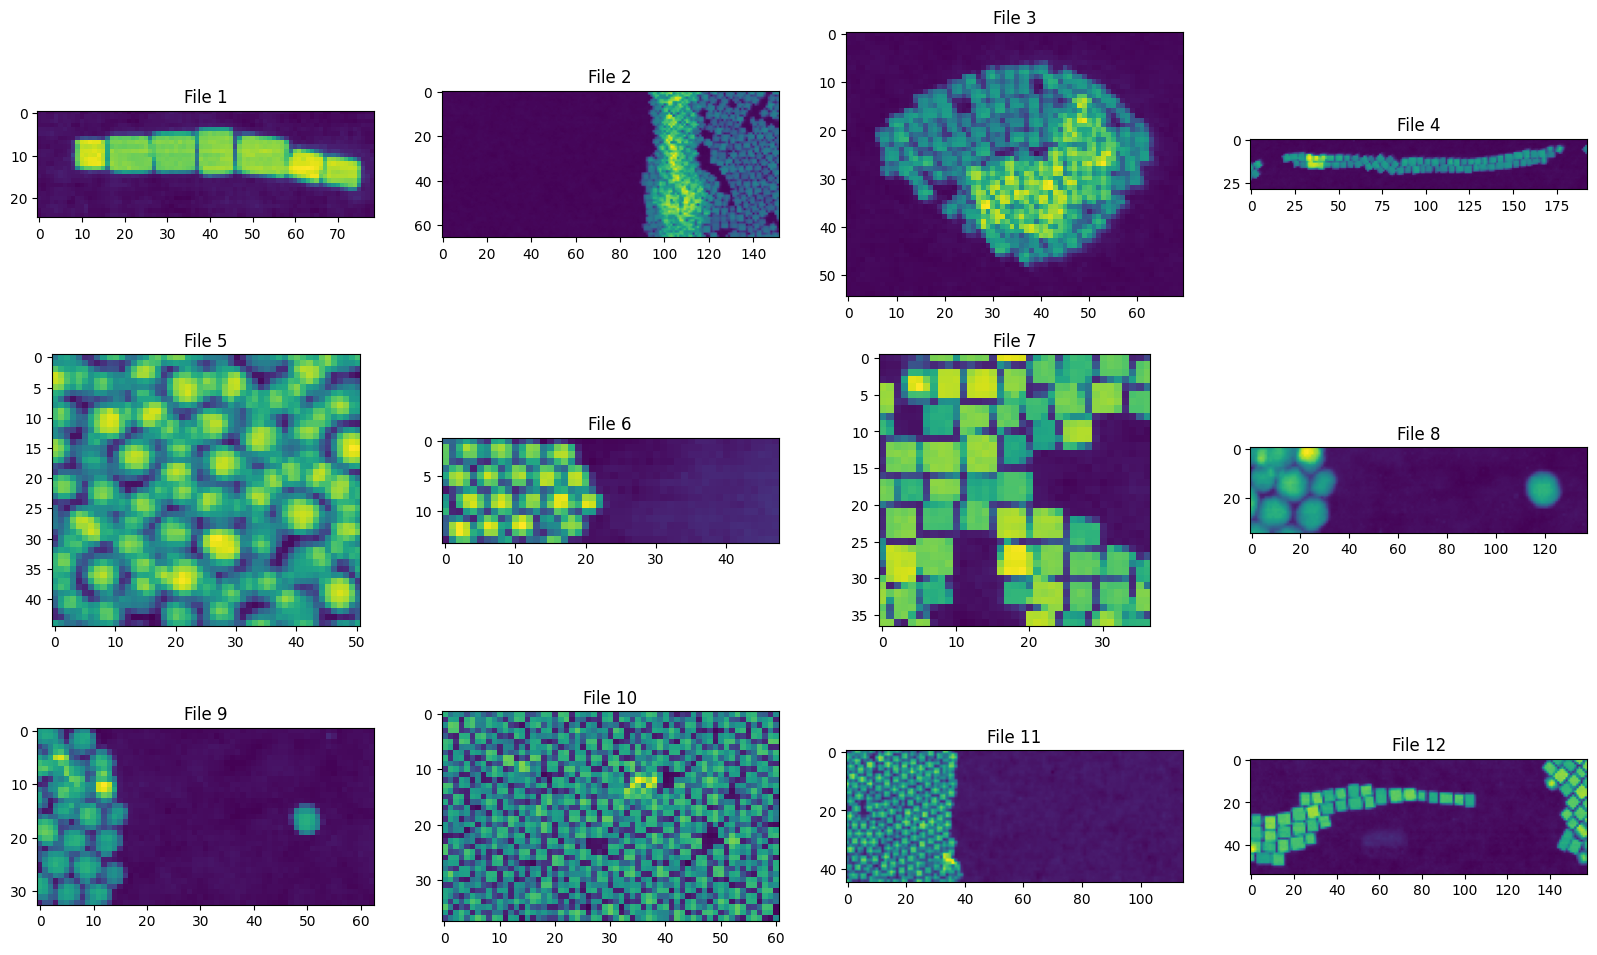

In [15]:
num_im = len(loadedfile)
rows = int(np.ceil(float(num_im)/4))
cols = int(np.ceil(float(num_im)/rows))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (5*cols, 3*(1+rows)))

for kk in range(num_im):
    ax = fig.add_subplot(gs[kk])
    fileset  = loadedfile['{}'.format(kk+1)]
    f1,f2,f3,f4 = fileset
    img, data, e_ax, img_scale = fileset[f1], fileset[f2], fileset[f3], fileset[f4]
    ax.imshow(img)
    ax.set_title("File {}".format(kk+1))

In [16]:
# Choose the file for analysis

k = 12
img = loadedfile['{}'.format(k)]['image']
specim = loadedfile['{}'.format(k)]['spectrum image']
e_ax = loadedfile['{}'.format(k)]['energy axis']
imscale = loadedfile['{}'.format(k)]['scale']

In [17]:
# Read grid spectoscopy data

hdata = specim
hdata = hdata.astype(np.float64)

In [18]:
hdata.shape

(54, 158, 1772)

Visual inspection of the :

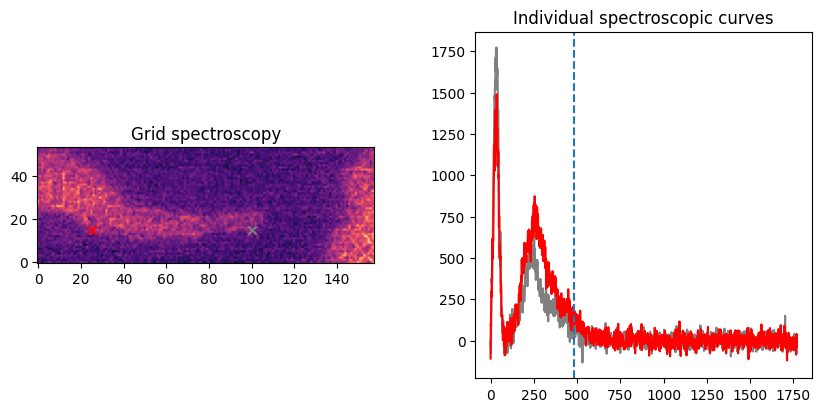

In [19]:
# Select a slice and points for extracting idividual spectoscopic curves
# For convenience, we look at the data in pixels (however, we store the real scale as e_ax)

s = 480 # slice
pos1 = [100, 15]
pos2 = [25, 15]

# Plot
_, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(hdata[..., s], cmap='magma', origin="lower")
ax[0].scatter(pos1[0], pos1[1], c='gray', marker='x')
ax[1].plot(hdata[pos1[1], pos1[0], :], c='gray')
ax[0].scatter(pos2[0], pos2[1], c='red', marker='x')
ax[1].plot(hdata[pos2[1], pos2[0], :], c='red')
ax[1].axvline(x=s, linestyle = '--')
ax[0].set_title('Grid spectroscopy')
ax[1].set_title('Individual spectroscopic curves')
plt.subplots_adjust(wspace=.3)

Important considerations for subsequent analysis.
 - For "real" analysis, make sure that before any subsequent analysis the data is properly curated. For EELS this is zero loss peak subtraction and log-log deconvolution. This will affect analysis very strongly (e.g. zerol-loss peak will dominate everything if not accounted for).
 - You can also consider downsampling the data (just average pool).
 - Finally, always keep track on whether you normalize data and how (all spectra 0 to 1, or all normalized to total maximum)
 - And keep track on whether average is subtracted.
 - Normalization and average subtraction will affect the analysis results. In our experience, there is no right way or wrong way for doing it - different preprocessing highlights dissimilar aspects of the physics of the system. However, it is important to keep track of these.  

In [20]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

In [21]:
d1, d2, d3

(54, 158, 1772)

Here we run the PCA analysis on EELS to visualzie the results

In [22]:
# Select number of components
nc = 12

# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'PCA'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(12, 1772) (8532, 12)


NUMBER OF COMPONENTS: 12
Components...


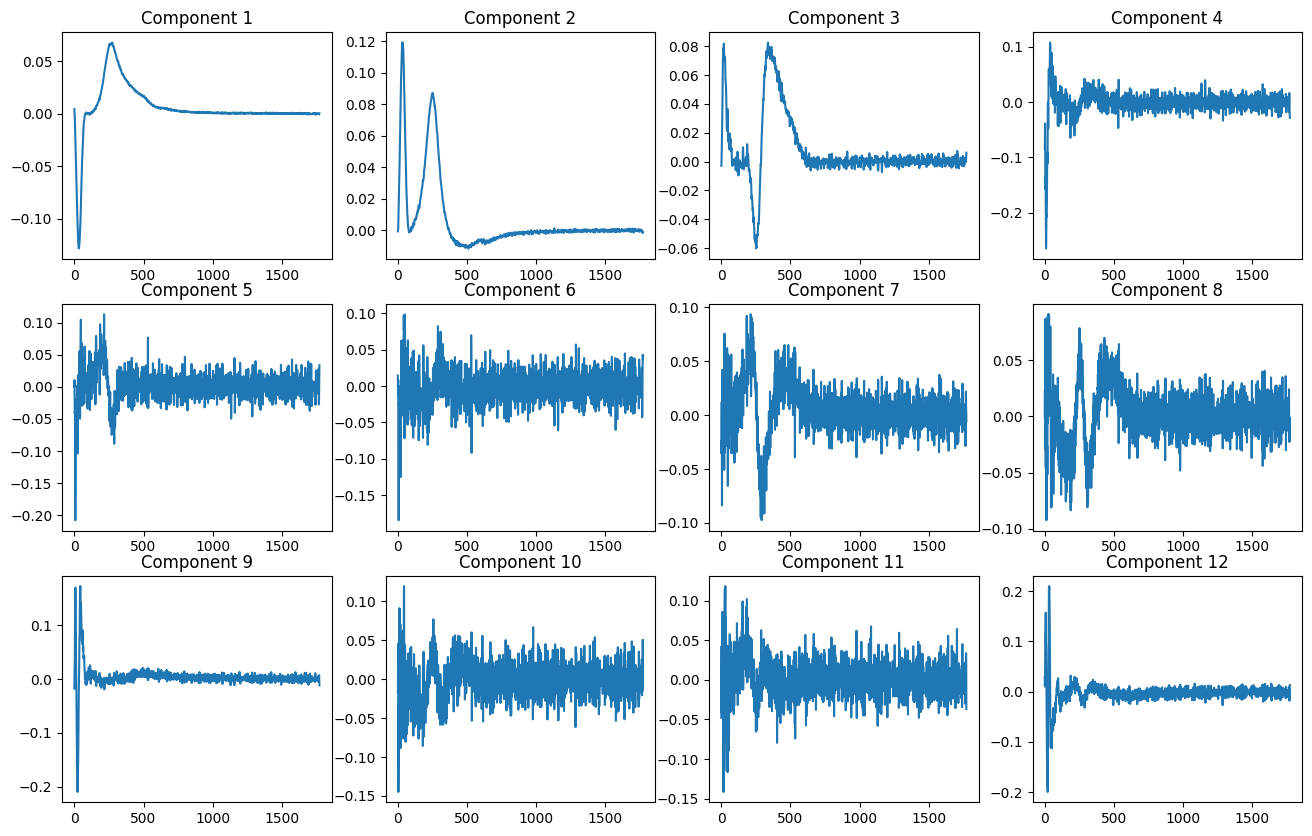

Abundance maps...


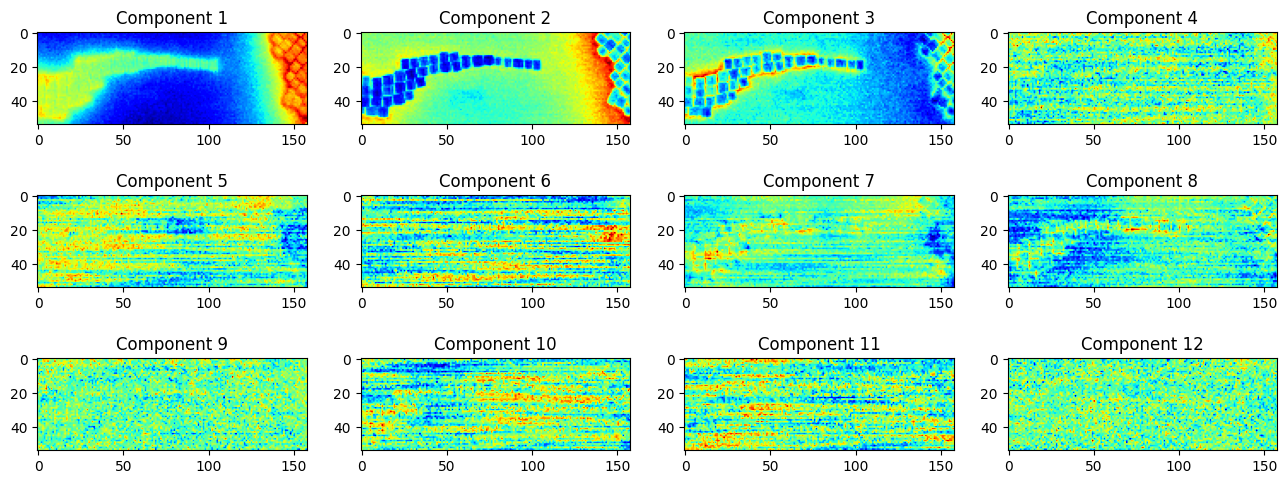

In [23]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 4*(1+rows)//1.5))
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    j = 0
    ax1.plot(components[i])
    ax1.set_title('Component ' + str(i + 1))
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 2*(1+rows//1.5)))
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    ax2.set_title('Component ' + str(i + 1))
plt.show()

10. Let's explore the QDA analysis on the EELS data set. Here, as a first step we need to create meaningful class labels. There are multiple ways we can make them based on the prior knowledge, physical intuition, or curiosity. Here, pick one of the three ways:
- Using the PCA images as a guide, identify ~10 points/class as class 1, 2, ... . Note that one class should be in the empty space (e.g. point (0,0) and few similar ones). Others can be identified as corners of the nanoparticle clusters, etc. In other words, we identify possible classes for spectra based on structural similarity of images
- We can also use the PCA maps to help "identify" classes. For example, using the peak finding function to identify dark/bright points on one of the PCA maps
- The output will be the 2D array of the same size as the the image, with most of the points having class label 0 and others being class labels 1, 2, ...


Making the labels

Text(0.5, 1.0, 'Area around points')

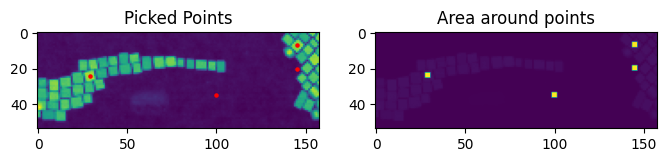

In [24]:
# Here we will pick important points in the image and the spectra around those points will be labeled as a single class
inds = [[100,35],   # Empty space
        [145,7],  #Right Cluster
        [29,24],   # Left cluster
        [145,20],  # edge of right cluster
        # [20,20],   # edge of left cluster
        ]


# Visulizing the points picked and regions around them

fig, ax = plt.subplots(ncols = 2, figsize = (8, 3))
ax[0].imshow(img)
for ind in inds:
    ax[0].scatter(ind[0], ind[1], c= 'r', s = 5)
ax[0].set_title('Picked Points')

img_new = dc(img)  # Deep Copy image
for ind in inds:
    img_new[ind[1]-1:ind[1]+2, ind[0]-1:ind[0]+2] = 1

ax[1].imshow(img_new)
ax[1].set_title('Area around points')

Class:  0.0 , Elements:  8469
Class:  1.0 , Elements:  36
Class:  2.0 , Elements:  9
Class:  3.0 , Elements:  9
Class:  4.0 , Elements:  9


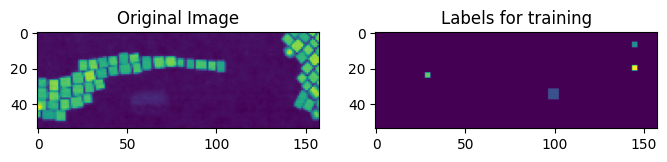

In [25]:
# Now that we have picked the points, let's populate the labels array
labels = np.zeros([d1, d2])

for i, ind in enumerate(inds):
    if i == 0:
        # We can pick a lot of points in the empty space
        labels[ind[1]-3:ind[1]+3, ind[0]-3:ind[0]+3] = i+1
    else:
        labels[ind[1]-1:ind[1]+2, ind[0]-1:ind[0]+2] = i+1

# Visualizing the labels
fig, ax = plt.subplots(ncols = 2, figsize = (8, 3))
ax[0].imshow(img)
ax[0].set_title('Original Image')

ax[1].imshow(labels)
ax[1].set_title('Labels for training')

u, counts = np.unique(labels, return_counts =True)
for i in range(len(u)):
    print('Class: ', u[i], ', Elements: ', counts[i])

labels_flat = labels.flatten()

11. Run the QDA analysis on the selected classes (meaning ignore the class 0 points)

In [26]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(X_vec[labels_flat !=0 ], labels_flat[labels_flat !=0])

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

We can do a better job in picking the classes to avoid collinearity but that's not the point.

12. Using the trained QDA model, classify the remaining spectra. Visualize the class labels image

Text(0.5, 1.0, 'Predicted labels by QDA')

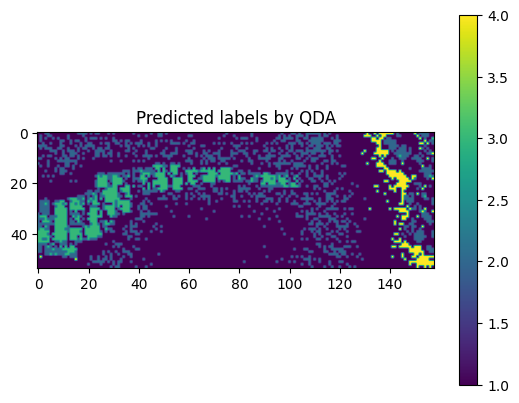

In [27]:
qda_pred = QDA.predict(X_vec)
plt.imshow(qda_pred.reshape([d1, d2]))
plt.colorbar()
plt.title('Predicted labels by QDA')

# Problem 4 - MLR on EELS

Now, let's run the multiple regression analysis on the EELS data set. Here, we represent each EELS spectrum A(x,y,E) as a linear combination of endmember spectra A_i(E), i.e. try to find linear coefficients a1, a2, ... , an in A(x,y,E) = a1(x,y) A_1(E) + a2(x,y) A_2(E) + ... + an(x,y) A_n(E). Unlike the PCA analysis, the endmembers A_i(E) are **known**.

13. Create the endmembers by averaging within the classes that you created above

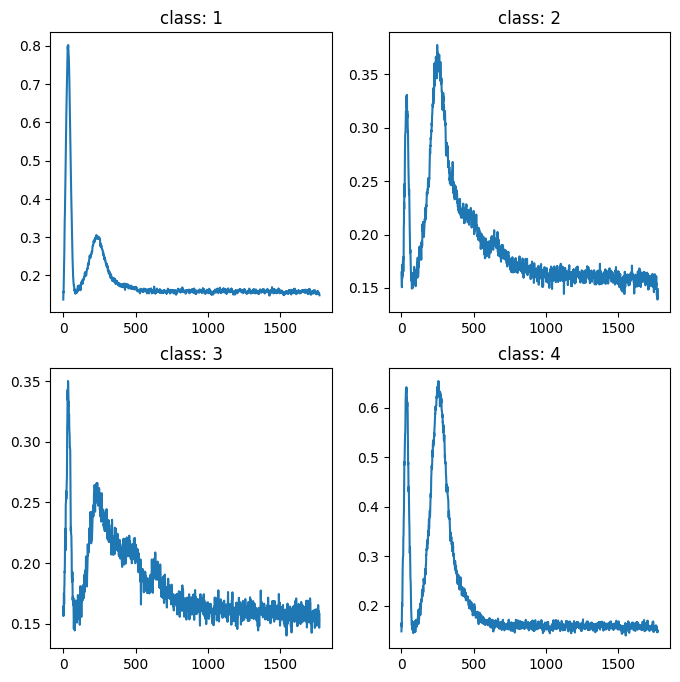

In [28]:
# Here we can use the predicted labels on the entire image or just the training dataset (Either works)
# I am using just the training dataset
endmembers = np.zeros([4, d3]) # 5 classes
for i in range(len(endmembers)):
    # print(np.sum(labels_flat == i+1))
    endmembers[i] = np.mean(X_vec[labels_flat == i+1], axis = 0)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.plot(endmembers[i])
    ax.set_title('class: '+str(i+1))

14. Create the function that takes unknown spectrum A(E) and known endmember spectra A_i(E), and fits A(E) with linear function A(x,y,E) = a1(x,y) A_1(E) + a2(x,y) A_2(E) + ... + an(x,y) A_n(E) to yield the constants a1, ..., an and fit error. Show the results of the fit for several points.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def fit_spectrum(A, end_members):
    """
    Fit the spectrum A(E) as a linear combination of the spectra in end_members.

    Parameters:
    A (numpy.ndarray): The target spectrum with shape (1772,).
    end_members (numpy.ndarray): The spectra to use as features with shape (6, 1772).

    Returns:
    tuple: A tuple containing:
        - coefficients (numpy.ndarray): The coefficients of the linear combination (a1, ..., a6).
        - fit_error (float): The mean squared error of the fit.
    """

    # Transpose end_members from (6, 1772) to (1772, 6) to fit the sklearn's expected input format
    X = end_members.T  # Now it has shape (1772, 6)

    # Reshape A for sklearn
    y = A.reshape(-1, 1)  # Now it has shape (1772, 1)

    # Create a linear regression model
    model = LinearRegression(fit_intercept=False)

    # Fit the model
    model.fit(X, y)

    coefficients = model.coef_

    # Predict the values
    y_pred = model.predict(X)

    fit_error = mean_squared_error(y, y_pred)




    return coefficients, y_pred.squeeze(), fit_error

In [30]:
# Now we loop the function over the entire dataset
X_vec_pred = np.zeros_like(X_vec)
coeffs = np.zeros([X_vec.shape[0],  4])
residuals = np.zeros(X_vec.shape[0])

for i, x_vec in enumerate(X_vec):
    coeffs[i], X_vec_pred[i], residuals[i] = fit_spectrum(x_vec, endmembers)


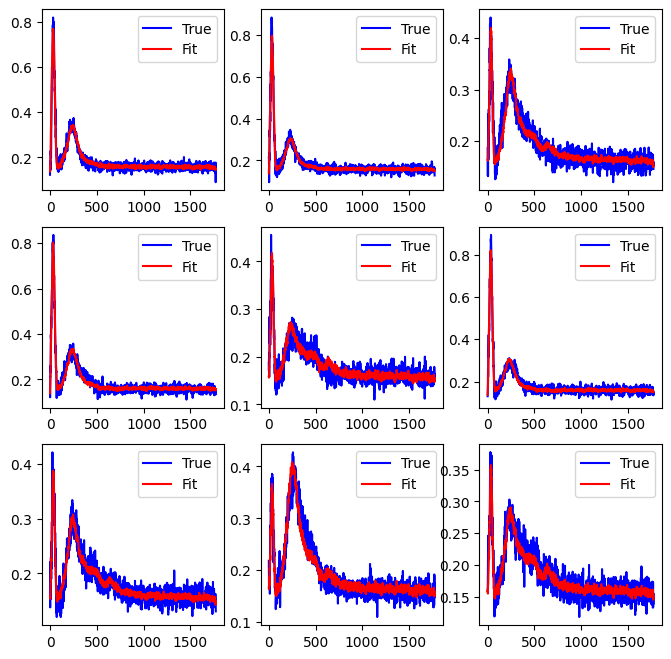

In [31]:
inds = np.random.choice(np.arange(X_vec.shape[0]), replace = False, size = 9)
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.plot(X_vec[inds[i]], c = 'b', label = 'True')
    ax.plot(X_vec_pred[inds[i]], c = 'r', label = 'Fit')
    ax.legend()

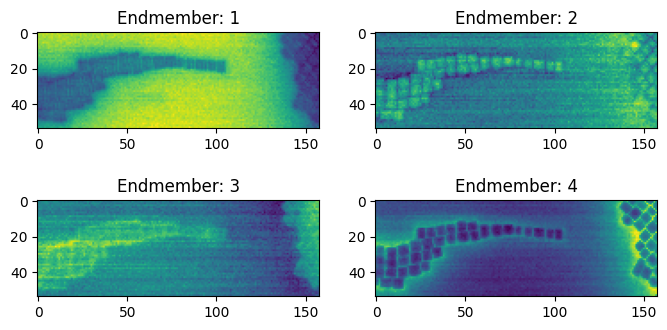

In [32]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(coeffs[..., i].reshape([d1, d2]))
    ax.set_title('Endmember: '+str(i+1))

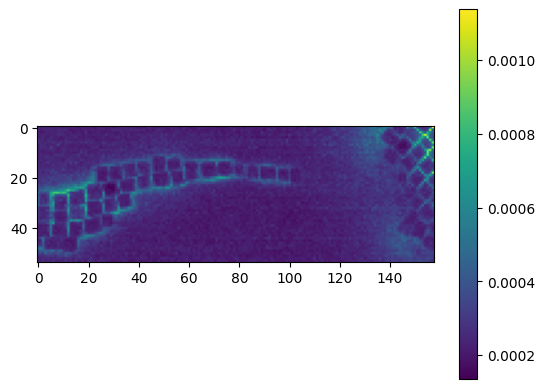

In [33]:
# Residuals plot
plt.imshow(residuals.reshape([d1, d2]))
plt.colorbar()